<a href="https://colab.research.google.com/github/zardemostoles/zardemostoles-uoc.edu/blob/master/TFG_Modelo_Diagnostico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Este notebook está inspirado por:
# TFRecord Experiments - Upsample and Coarse Dropout
# https://www.kaggle.com/code/cdeotte/tfrecord-experiments-upsample-and-coarse-dropout/notebook
# Splitting TensorFlow Dataset for Validation
# https://www.kaggle.com/code/tt195361/splitting-tensorflow-dataset-for-validation/notebook
# Rotation Augmentation GPU/TPU - [0.96+]
# https://www.kaggle.com/code/cdeotte/rotation-augmentation-gpu-tpu-0-96/notebook
# Classification on imbalanced data
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#optional_set_the_correct_initial_bias

In [ ]:
# Se instala EfficientNet
!pip install -q efficientnet

     |████████████████████████████████| 50 kB 3.1 MB/s 


In [ ]:
# Se importan los módulos que se van a utilizar en el notebook

# Módulos básicos
import math
import numpy as np
import matplotlib.pyplot as plt

# Módulo para mostrar imágenes
import PIL

# Módulo para realizar la particiones de datos
from sklearn.model_selection import train_test_split

# Módulos de TensorFLow y Keras
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import load_model

# Módulo de EfficientNet
import efficientnet.tfkeras as efn

In [ ]:
# Se comprueba la versión de TensorFlow
print(tf.__version__)
print(tf.keras.__version__)

# Preprocesamiento y entrenamiento de TensorFlow (prefetch) automático
AUTO = tf.data.AUTOTUNE

2.9.2
2.9.0


## Definición de funciones



### Funciones de tratamiento de TFRecords y Datasets

In [ ]:
# Función para convertir una imagen en un tensor, creando un tensor con las 
# dimensiones requeridas y normalizado.
# image: representación RGB de la imagen 
# size: dimensiones del tensor a los que se redimensiona (variable global)
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    # Dimensiona a las dimesiones del tensor
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    # Normaliza los pixeles en el rango [0, 1]
    image = tf.cast(image, tf.float32) / 255.0 
    return image

# Función para extraer de un TFRecord la imagen, el nombre de la imagen y 
# el diagnóstico.
def read_labeled_tfrecord_with_file_name(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "image_name": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        "patient_id": tf.io.FixedLenFeature([], tf.int64),
        "sex": tf.io.FixedLenFeature([], tf.int64),
        "age_approx": tf.io.FixedLenFeature([], tf.int64),
        "anatom_site_general_challenge": tf.io.FixedLenFeature([], tf.int64),
        "diagnosis": tf.io.FixedLenFeature([], tf.int64),
        "target": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    image_name = example['image_name']
    target = tf.cast(example['target'], tf.int32)
    return image, image_name, target


# Función para filtrar los registros cuyo nombre de imágen no termine con
# '_downsample'
def filter_images(image, image_name, target):
  return not tf.strings.regex_full_match(image_name,"^((.*_downsampled))")

# Función para filtrar los registros con diagnóstico de melanoma
def filter_images_melanoma(image, image_name, target):
  return target == 1

# Función para filtrar los registros con diagnóstico de no melanoma
def filter_images_no_melanoma(image, image_name, target):
  return target == 0

# Función para suprimir el nombre del fichero de los registros
def remove_file_name(image, file, target):
  return image, target

# Función para cargar en un dataset los TFRecords de un conjunto de registros
def load_dataset(filenames):
    # Lecturas en paralelo
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    # Construye el dataset con el formato definido,
    # descartando los que sean 'downsample'
    dataset = dataset.map(read_labeled_tfrecord_with_file_name, 
                          num_parallel_calls=AUTO).filter(filter_images)
    # Devuekve un dataset con )image, image_name, target)
    return dataset


# Función para extraer un dataset de otro dataset dados los índices
# (se utiliza para particionar un dataset)
def get_selected_dataset(ds, X_indices_np):
    # Crea un tensor del tipo tf.int64 como el de Dataset.enumerate(). 
    X_indices_ts = tf.constant(X_indices_np, dtype=tf.int64)
    
    # Función que devuelve True si el índice esta incluido en X_indices_ts
    def is_index_in(index, rest):
        return tf.math.reduce_any(index == X_indices_ts)
    
    def drop_index(index, rest):
        return rest

    # Dataset.enumerate() is similter to Python's enumerate().
    # Se filtran los indices que se han pasado como parámetro y se devuelve el
    # dataset con dichos índices
    selected_ds = ds \
        .enumerate() \
        .filter(is_index_in) \
        .map(drop_index)
    return selected_ds

# Función que realiza 'data augmentation' sobre una imagen
def data_augment(image, target):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image  = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.1)
    return image, target

# Función que devuelve el dataset de entrenamiento
def get_training_dataset(ds, do_augment=False):
    dataset = ds
    dataset = ds.map(remove_file_name)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    if do_augment:  dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.prefetch(AUTO) 
    return dataset

# Función que devuelve el dataset de validación
def get_validation_dataset(ds):
    dataset = ds
    dataset = ds.map(remove_file_name)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # 
    return dataset

# Función que devuelve el dataset de prueba
def get_test_dataset(ds):
    dataset = ds
    #dataset = ds.map(remove_file_name)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # 
    return dataset

### Funciones para el entrenamiento del modelo


In [ ]:
# Función de checkpoint para guardar el mejor modelo según una métrica 
# durante el entrenamiento
def make_model_check_point(best_model_file_path, metric='val_auc_pr'):
    return ModelCheckpoint(
        best_model_file_path, monitor=metric, mode='max',
        verbose=1, save_best_only=True, save_weights_only=False, period=1)

# Funcióm para crear un modelo EfficientNet
def create_model(lr=0.00005, init_bias=False, 
                 dropout=0.2, dense_bias_initializer=0):
  BATCH_SIZE = 16 * strategy.num_replicas_in_sync
  resolution = "384x384"
  IMAGE_SIZE = RESOLUTIONS[resolution]
  K.clear_session()

  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

  with strategy.scope():
      if init_bias:
          model = Sequential([
            efn.EfficientNetB4(
                include_top=False, weights="noisy-student",  #'noisy-student', #imagenet
                input_shape=(*IMAGE_SIZE, 3), pooling='avg'),
            Dropout(
                dropout, name="dropout"),
            Dense(1, bias_initializer=dense_bias_initializer,
                activation='sigmoid',name='classify')
        ])
      else:
          model = Sequential([
            efn.EfficientNetB4(
                include_top=False, weights='noisy-student',
                input_shape=(*IMAGE_SIZE, 3), pooling='avg'),
            Dropout(
                dropout, name="dropout"),
            Dense(
                1, activation='sigmoid',name='classify')
        ])
      metrics = [ AUC(name='auc_roc', curve='ROC'), 
                 AUC(name='auc_pr', curve='PR'),
                 Precision(name='precision'), Recall(name='recall') ]  

  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
  model.summary()
  return model

# Función para mostrar una curva de rendimiento del entrenamiento
def display_training_curve(training, validation, title, subplot, ylim):
  # Se definen los subplots en la primera llamada
  if subplot%10==1: 
      plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
      plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title(title)
  ax.set_ylabel(title)
  ax.set_ylim(*ylim)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

# Función para mostrar las curvas de rendimiento del entrenamiento de modelo    
def display_curves(history):
  display_training_curve(
      history.history['loss'], history.history['val_loss'],
      'loss', 221, (0.0, 0.5))
  display_training_curve(
      history.history['auc_roc'], history.history['val_auc_roc'],
      'AUC ROC', 222, (0.5, 1.0))
  display_training_curve(
      history.history['precision'], history.history['val_precision'],
      'precision', 223, (0.0, 1.0))
  display_training_curve(
      history.history['recall'], history.history['val_recall'],
      'recall', 224, (0.0, 1.0))   

### Funciones de visualización de imágenes

In [ ]:
# Dots per Inch para mostrar imágenes en un monitor de resolución 1366x768
MY_DPI = 96

# Función que muestra en pantalla las imágenes contenidas en un dataset con
# su correspondiente diagnóstico (etiqueta)
def show_sample_images(thumb_size, ds):
  for img, file, target in iter(ds):
    plt.figure(figsize=(thumb_size/MY_DPI, thumb_size/MY_DPI), dpi=MY_DPI)
    file_name = file.numpy().decode('ascii')
    target_diag = "Melanoma" if target.numpy() else "No melanoma"
    image = np.clip(img.numpy() * 255, 0, 255).astype(np.uint8)
    image = PIL.Image.fromarray(image)
    print("File: {} Size: {} Diagnóstico: {}".format(file_name, image.size,target_diag))
    plt.imshow(image)
    plt.show()
    print("\n")

# Función para mostrar un mosaico con imágenes
def show_mosaic_images(thumb_size, cols, rows, ds):
    mosaic = PIL.Image.new(mode='RGB', size=(thumb_size*cols + (cols-1), thumb_size*rows + (rows-1)))
    for idx, data in enumerate(iter(ds)):
        img, target = data[0], data[1]
        ix  = idx % cols
        iy  = idx // cols
        img = np.clip(img.numpy() * 255, 0, 255).astype(np.uint8)
        img = PIL.Image.fromarray(img)
        img = img.resize((thumb_size, thumb_size), resample=PIL.Image.BILINEAR)
        mosaic.paste(img, (ix*thumb_size + ix, 
                           iy*thumb_size + iy))
        if idx > cols*rows: break
    display(mosaic)

### Funciones auxiliares

In [ ]:
# Función para imprimir el total de casos de cada categoría y el el porcentaje de 
# la categoría positiva respecto al total
def print_target_counts(y, label):
    _, y_counts = np.unique(y, return_counts=True)
    y_total = len(y)
    y_0_count = y_counts[0]
    y_1_count = y_counts[1]
    y_1_percent = y_1_count / y_total * 100.0
    print("{0:10s}: Total={1:5d}, 0={2:5d}, 1={3:3d}, porcentaje de melanoma={4:.2f}%".format(
        label, y_total, y_0_count, y_1_count, y_1_percent))

## Configuración del entorno hardware

In [ ]:
# Detecta hardware, devuelve la estrategia de distribución apropiada el HW.
try:
    # TPU detectada 
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('TPU disponible ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()
    print("GPUs disponibles: ", len(tf.config.list_physical_devices('GPU')))

print("Réplicas:", strategy.num_replicas_in_sync)

# Configura el tamaño del batch
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
print("Tamaño de batch:", BATCH_SIZE)

TPU disponible  grpc://10.35.107.194:8470
Réplicas: 8
Tamaño de batch: 128


## Carga de los ficheros de TFRecords en datasets

In [ ]:
# Ruta a los ficheros de TFRecords en GCS
GCS_PATHS = {
  #"256x256": "gs://kds-ba3e7d448bf7bdcc890f1dbcce1a34e87acee697ceaaba697d9b5975",
  "384x384": "gs://kds-751ba037a14a150dd732a237b636cac654652a12d9adfeeed3e9441d",
  #"512x512": "gs://kds-9f453d1bb81796153f51085b3bb2eb73b2ca03501bdfc5a15011e3fc",
  #"768x768":  "gs://kds-96f5a566c923ab0c389beffbe7a714e300c09d8e3bb680ffdfaef6fc"
}

# Resoluciones que se van a utilizar para el entrenamiento del modelo
RESOLUTIONS = {
  #"256x256": [256, 256],
  "384x384": [384, 384],
  #"512x512": [512, 512],
  #"768x768": [768, 768]
}

# Resolución del imágenes modelo
MODEL_RESOLUTION = "384x384"
IMAGE_SIZE = RESOLUTIONS[MODEL_RESOLUTION]

# Carga los TFRecords 
dataset_files = {}
for resolution, path in GCS_PATHS.items():
    print("Resolución: {}, path: {}".format(resolution, path))
    dataset_files[resolution] = tf.io.gfile.glob(path + '/train*.tfrec')
    print("Ficheros TFRecord: ({})".format(len(dataset_files[resolution])))

Resolución: 384x384, path: gs://kds-751ba037a14a150dd732a237b636cac654652a12d9adfeeed3e9441d
Ficheros TFRecord: (30)


In [ ]:
# Carga de los conjuntos de datos desde los ficheros TFRecord
full_datasets = {}
for resolution, files in dataset_files.items():
  IMAGE_SIZE = RESOLUTIONS[MODEL_RESOLUTION]
  full_datasets[resolution] = load_dataset(files)
  print(resolution, full_datasets[resolution])


384x384 <FilterDataset element_spec=(TensorSpec(shape=(384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>


## Visualización de ejemplos de imágenes

File: ISIC_0000002 Size: (384, 384) Diagnóstico: Melanoma


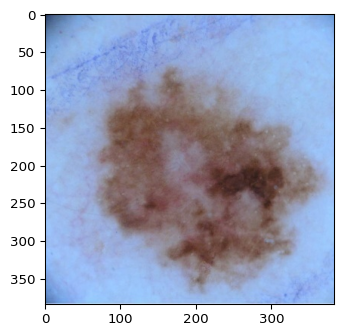



File: ISIC_0053467 Size: (384, 384) Diagnóstico: No melanoma


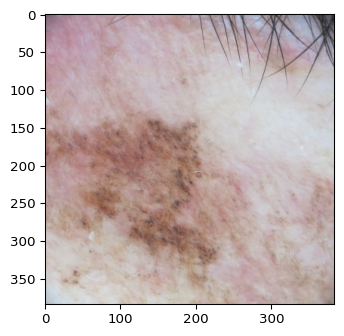

Exception ignored in: <function Executor.__del__ at 0x7ff0d3dabe50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


In [ ]:
# Muestra 2 ejemplos de imágenes
examples = full_datasets[MODEL_RESOLUTION].take(2)
show_sample_images(RESOLUTIONS[MODEL_RESOLUTION][0], examples)



### Visualización de ejemplos de imágenes con diagnóstico de melanoma

Exception ignored in: <function Executor.__del__ at 0x7ff0d3dabe50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


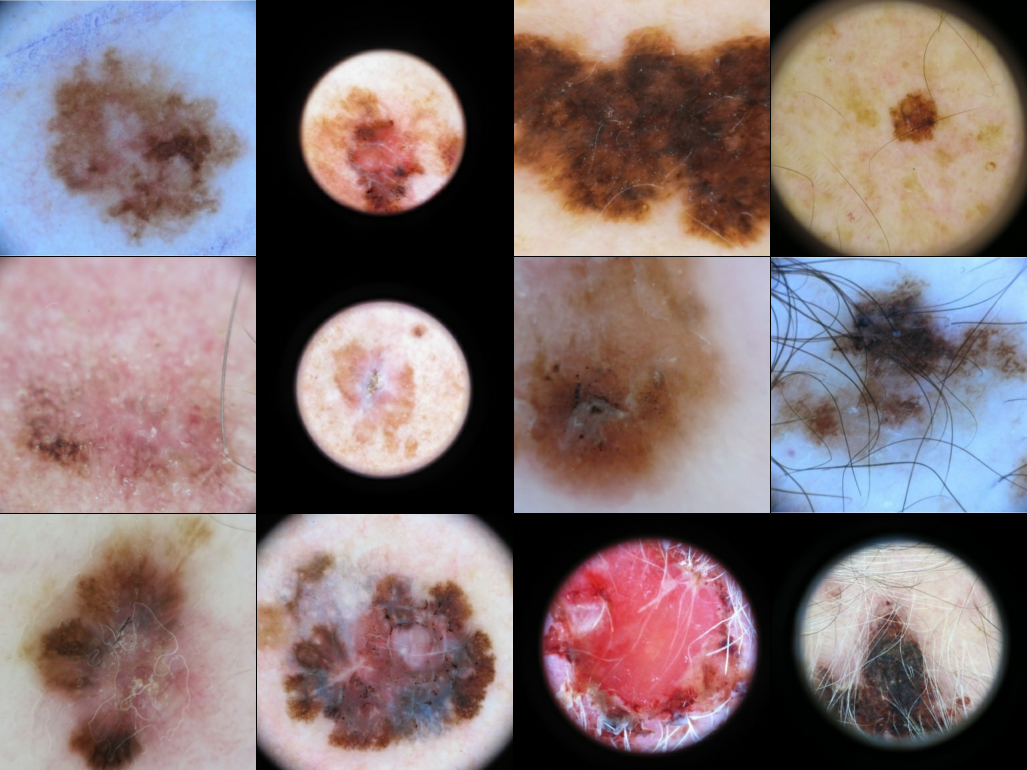

In [ ]:
ds = full_datasets[MODEL_RESOLUTION].filter(filter_images_melanoma).take(4*3) 
show_mosaic_images(256, 4, 3, ds)

### Visualización de ejemplos de imágenes con diagnóstico de no melanoma

Exception ignored in: <function Executor.__del__ at 0x7ff0d3dabe50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


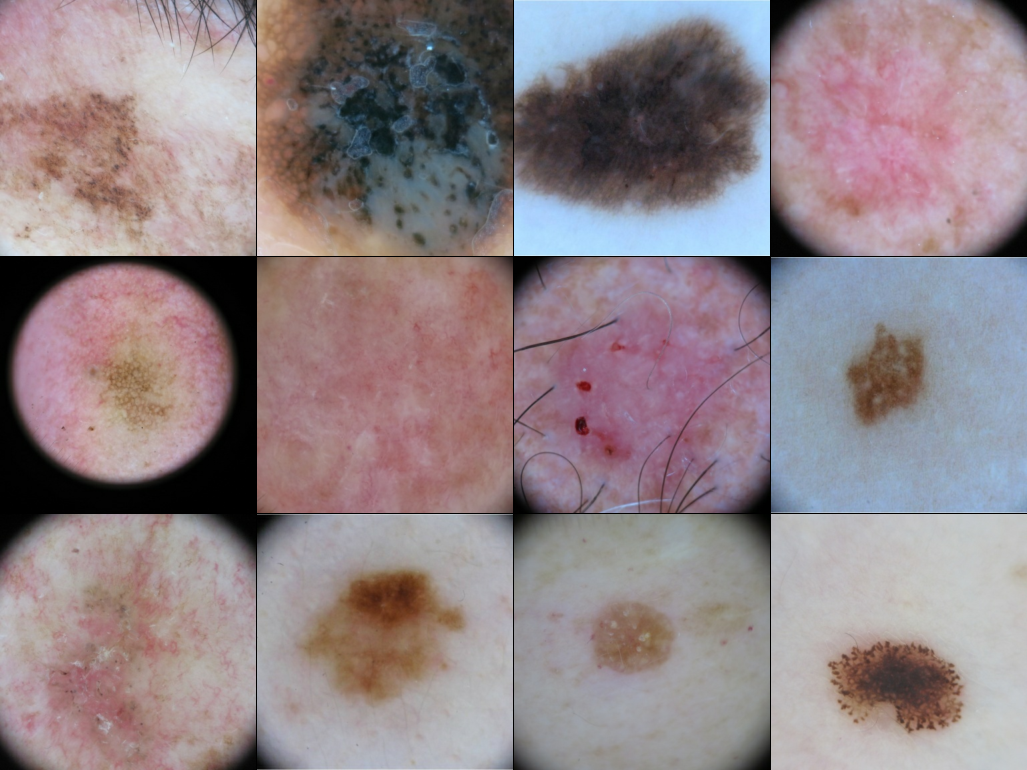

In [ ]:
ds = full_datasets[MODEL_RESOLUTION].filter(filter_images_no_melanoma).take(4*3)
show_mosaic_images(256, 4, 3, ds)

## Preparación del conjunto de datos para experimentos y para prueba

El conjunto de datos de prueba se separa y solamente se usa con el modelo ya entrenado para evaluar el rendimiento y la equidad del modelo.

In [ ]:
# Extrae los valores de los diagnósticos (etiqueta) para el conjunto de datos completo.
# Se generan los indices que son utilizados para filtrar en dataset.
y_targets = np.array([target.numpy() for img, file, target in iter(full_datasets[MODEL_RESOLUTION])])
X_indices = np.arange(len(y_targets))

print_target_counts(y_targets, "Total")

Exception ignored in: <function Executor.__del__ at 0x7ff0d3dabe50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Total     : Total=23218, 0=19076, 1=4142, porcentaje de melanoma=17.84%


In [ ]:
# Muestra la distribución de los diagnósticos del conjunto de datos completo
y_targets = np.array([ target.numpy() for img, file, target in iter(full_datasets[MODEL_RESOLUTION]) ])
X_indices = np.arange(len(y_targets))

print_target_counts(y_targets, "Total")

Exception ignored in: <function Executor.__del__ at 0x7ff0d3dabe50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Total     : Total=23218, 0=19076, 1=4142, porcentaje de melanoma=17.84%


In [ ]:
# Particiona el conjunto de datos completo en datos para experimentos 
# y para pruebas
X_exp_indices, X_test_indices, y_exp_targets, y_test_targets = train_test_split(
    X_indices, y_targets, test_size=0.15, stratify=y_targets, random_state=53)

# Muestra la distrubución de los diagnósticos en el conjunto de 
# experimentos y de pruebas
print_target_counts(y_exp_targets, "Entrenamiento:")
print_target_counts(y_test_targets, "Prueba:")

Entrenamiento:: Total=19735, 0=16214, 1=3521, porcentaje de melanoma=17.84%
Prueba:   : Total= 3483, 0= 2862, 1=621, porcentaje de melanoma=17.83%


In [ ]:
# Crea los datasets para entrenamiento (experiment_datasets) 
# y para pruebas (test_datasets)
experiment_datasets = {}
test_datasets = {} 
for resolution, full_dataset in full_datasets.items():
  experiment_datasets[resolution] =  get_selected_dataset(full_dataset, X_exp_indices)
  test_datasets[resolution] =  get_selected_dataset(full_dataset, X_test_indices)

print(experiment_datasets)
print(test_datasets)

{'384x384': <MapDataset element_spec=(TensorSpec(shape=(384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>}
{'384x384': <MapDataset element_spec=(TensorSpec(shape=(384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>}


In [ ]:
# Muestra la distrubución de los diagnósticos en el conjunto de entrenamiento
y_targets = np.array([ target.numpy() for img, file, 
                      target in iter(experiment_datasets[MODEL_RESOLUTION])])
print_target_counts(y_targets, "Total")

Exception ignored in: <function Executor.__del__ at 0x7ff0d3dabe50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Total     : Total=19735, 0=16214, 1=3521, porcentaje de melanoma=17.84%


In [ ]:
# Muestra la distribución de los diagnósticos en el conjunto de pruebas
y_targets = np.array([ target.numpy() for img, file, target in iter(test_datasets[MODEL_RESOLUTION])])
print_target_counts(y_targets, "Total")

Exception ignored in: <function Executor.__del__ at 0x7f807a477d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Total     : Total= 3483, 0= 2862, 1=621, porcentaje de melanoma=17.83%


## Preparación de el conjunto de datos para entrenamiento y para validación

El conjunto de datos de experimientos se particiona en conjunto de datos de entrenamiento y de validación. El conjunto de datos de validación se emplea para ajustar los parámetros del modelo y son vistos por el modelo durante el entrenamiento.

In [ ]:
# Se divide el conjunto de datos de experimentos en conjunto de datos 
# de entrenamimiento y conjunto de datos de validación

# Extrae los valores de los diagnósticos (etiqueta) para el conjunto de datos de experimentos
# Se generan los indices que son utilizados para filtrar en dataset.
y_targets = np.array([ target.numpy() for img, file, 
                      target in iter(experiment_datasets[MODEL_RESOLUTION])])
X_indices = np.arange(len(y_targets))

X_train_indices, X_val_indices, y_train_targets, y_val_targets = train_test_split(
    X_indices, y_targets, test_size=0.15, stratify=y_targets, random_state=53)

# Número de imágenes que se van a usar para entrenamiento y para validación
NUM_TRAINING_IMAGES = len(y_train_targets)
NUM_VALIDATION_IMAGES = len(y_val_targets)

print_target_counts(y_train_targets, "Entrenamiento")
print_target_counts(y_val_targets, "Validación")

Exception ignored in: <function Executor.__del__ at 0x7ff0d3dabe50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Entrenamiento: Total=16774, 0=13781, 1=2993, porcentaje de melanoma=17.84%
Validación: Total= 2961, 0= 2433, 1=528, porcentaje de melanoma=17.83%


In [ ]:
# Crea los datasets para entrenamiento y validación
training_datasets = {}
validation_datasets = {} 
for resolution, experiment_dataset in experiment_datasets.items():
  training_datasets[resolution] =  get_selected_dataset(experiment_dataset, X_train_indices)
  validation_datasets[resolution] =  get_selected_dataset(experiment_dataset, X_val_indices)

print(training_datasets)
print(validation_datasets)

{'384x384': <MapDataset element_spec=(TensorSpec(shape=(384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>}
{'384x384': <MapDataset element_spec=(TensorSpec(shape=(384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>}


## Preparación para el entrenamiento del modelo

In [ ]:
# Cálculo de los pasos por época
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

# Cálculo del bías inicial
_, (y_target_neg_count, y_target_pos_count) = np.unique(y_targets, return_counts=True)
y_target_pos_ratio = y_target_pos_count / y_target_neg_count
dence_initial_bias = math.log(y_target_pos_ratio)
dense_bias_initializer = Constant(dence_initial_bias)

print("No melanoma:" , y_target_neg_count, "Melanoma; ", y_target_pos_count)
print("Ratio:", y_target_pos_ratio)
print("Bias inicial:", dence_initial_bias)

No melanoma: 16214 Melanoma;  3521
Ratio: 0.21715801159491796
Bias inicial: -1.5271300263926


### Creación del modelo

In [ ]:
# Crea un modelo EfficientNet con los parámetros encontrados en los experimentos
model = create_model(lr=0.00005, init_bias=True, dropout=0.3, 
                       dense_bias_initializer=dense_bias_initializer)

# Path para el fichero donde se va a guardar el mejor modelo
best_model_file_path = "TFG_mejor_modelo.hdf5"

# crea un checkpoint para utilizar por el modelo
model_check_point = make_model_check_point(best_model_file_path)

71678424/71678424 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b4 (Functional  (None, 1792)             17673816  
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1792)              0         
                                                                 
 classify (Dense)            (None, 1)                 1793      
                                                                 
Total params: 17,675,609
Trainable params: 17,550,409
Non-trainable params: 125,200
_________________________________________________________________


## Entrenamiento del modelo

In [ ]:
# Semilla aleatoria para reproductibilidad
tf.keras.utils.set_random_seed(33)

# Se entrena el modelo
history = model.fit(
  get_training_dataset(training_datasets[MODEL_RESOLUTION]), 
  steps_per_epoch=STEPS_PER_EPOCH,
  epochs=15, validation_data=get_validation_dataset(validation_datasets[MODEL_RESOLUTION]),
  callbacks=[model_check_point], 
  verbose=1)

Epoch 1/15
131/131 [==============================] - ETA: 0s - loss: 0.3885 - auc_roc: 0.7825 - auc_pr: 0.5025 - precision: 0.6793 - recall: 0.2172
Epoch 1: val_auc_pr improved from -inf to 0.45174, saving model to TFG_mejor_modelo.hdf5
131/131 [==============================] - 237s 1s/step - loss: 0.3885 - auc_roc: 0.7825 - auc_pr: 0.5025 - precision: 0.6793 - recall: 0.2172 - val_loss: 0.5219 - val_auc_roc: 0.7185 - val_auc_pr: 0.4517 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/15
131/131 [==============================] - ETA: 0s - loss: 0.3245 - auc_roc: 0.8581 - auc_pr: 0.6381 - precision: 0.7196 - recall: 0.4114
Epoch 2: val_auc_pr improved from 0.45174 to 0.64214, saving model to TFG_mejor_modelo.hdf5
131/131 [==============================] - 55s 420ms/step - loss: 0.3245 - auc_roc: 0.8581 - auc_pr: 0.6381 - precision: 0.7196 - recall: 0.4114 - val_loss: 0.4403 - val_auc_roc: 0.8515 - val_auc_pr: 0.6421 - val_precision: 0.9762 - val_recall: 0.0777
Epoch 3/15


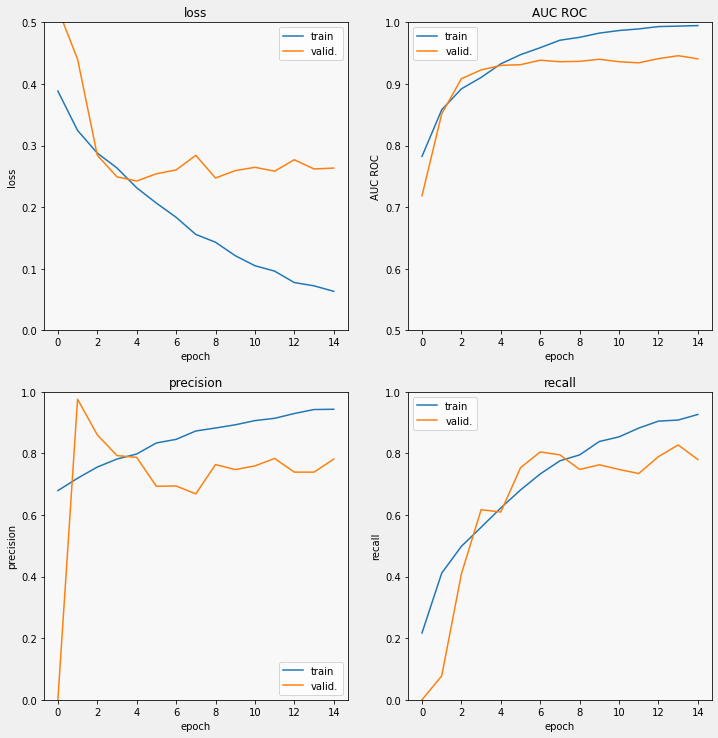

In [ ]:
# Se muestran las curvas de rendimiento del modelo durante el entrenamiento
display_curves(history)

In [ ]:
# Se monta el Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Se guarda el mejor modelo en un locación no volátil de Google Drivr
!mv /content/drive/MyDrive/TFG/TFG_mejor_modelo.hdf5 /content/drive/MyDrive/TFG/TFG_mejor_modelo.hdf5.back
!mv TFG_mejor_modelo.hdf5 /content/drive/MyDrive/TFG/TFG_mejor_modelo.hdf5

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Evaluación del modelo

### Evaluación del rendimiento del modelo

In [ ]:
# Se carga el mejor modelo
model2 = load_model('/content/drive/MyDrive/TFG/TFG_mejor_modelo.hdf5')

In [ ]:
# Se emplea el conjunto de datos de prueba para evaluar el rendimiento del modelo
# Etiquetas con el diagnóstico real
y_true = np.array([
  target.numpy() for img, file_name, 
  target in iter(get_test_dataset(test_datasets[MODEL_RESOLUTION]).unbatch())])

# Etiquetas con la predicción del modelo
y_pred = model2.predict(get_test_dataset(test_datasets[MODEL_RESOLUTION])).flatten()

print("Número de etiquetas con diagnósticos reales: ", y_true.shape)
print("Número de etiquetas predichas:", y_pred.shape)

Exception ignored in: <function Executor.__del__ at 0x7ff0d3dabe50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


28/28 [==============================] - 108s 4s/step
Número de etiquetas con diagnósticos reales:  (3483,)
Número de etiquetas predichas: (3483,)


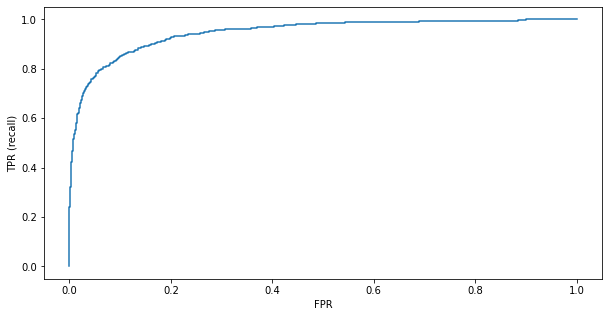

In [ ]:
# Curva ROC
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_pred)

plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.show()

In [ ]:
# AUC
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_true, y_pred)
print("AUC: {0:.3f}".format(auc))

AUC: 0.946


In [ ]:
# Matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Matriz de confusión @{:.2f}'.format(p))
    plt.ylabel('Diagnnóstico real')
    plt.xlabel('Diagnóstico predicho')

    print('Verdadero negativo: ', cm[0][0])
    print('Falso positivo: ', cm[0][1])
    print('Falso negativo: ', cm[1][0])
    print('Vardadero positivo: ', cm[1][1])
    #print('Número de imágenes con diagnóstico real de melanoma: ', np.sum(cm[1]))


Verdadero negativo:  2684
Falso positivo:  178
Falso negativo:  125
Vardadero positivo:  496


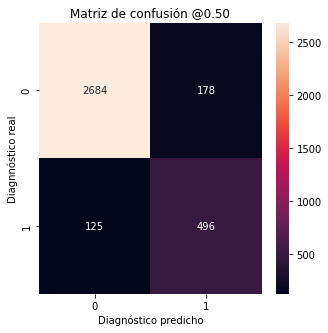

In [ ]:
# Muestra la matriz de confusión
plot_cm(y_true, y_pred, p=0.5)

In [ ]:
# Métricas precisión, sensibilidad y F1
from sklearn.metrics import precision_recall_fscore_support
y_pred_class = np.where(y_pred > 0.5, 1, 0)
precision_recall_fscore_support(y_true, y_pred_class)

(array([0.95550018, 0.73590504]),
 array([0.93780573, 0.79871176]),
 array([0.94657027, 0.76602317]),
 array([2862,  621]))

ISIC_0053515.png Real: No melanoma  - Predicción:[0.00018603]


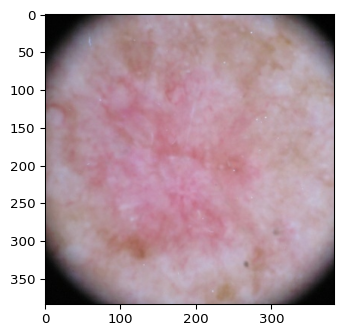

ISIC_0053456.png  Real: Melanoma  - Predicción:[0.9989362]


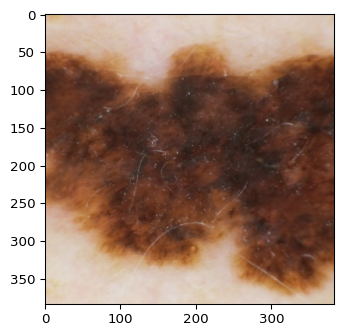

ISIC_0053493.png Real: No melanoma  - Predicción:[0.02325522]


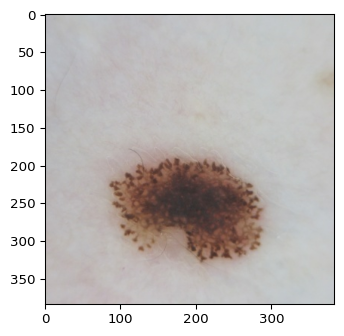

ISIC_0000199.png Real: No melanoma  - Predicción:[0.00579348]


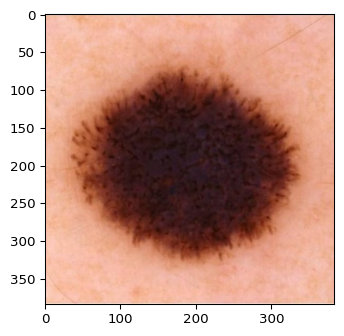

ISIC_0053483.png Real: No melanoma  - Predicción:[0.00221859]


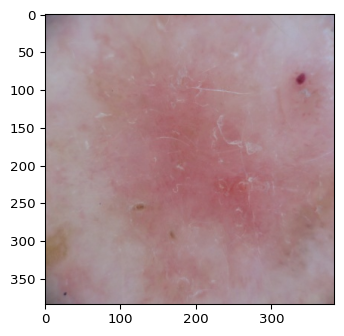

ISIC_0053534.png Real: No melanoma  - Predicción:[0.00041991]


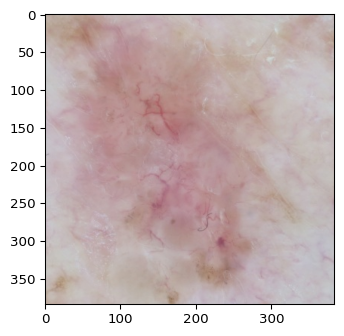

ISIC_0000072.png Real: No melanoma  - Predicción:[0.96895915]


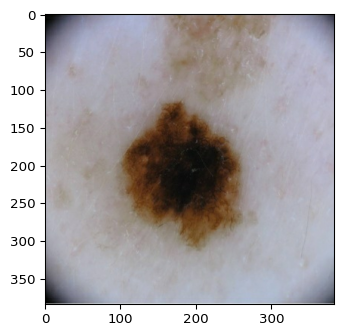

ISIC_0053615.png  Real: Melanoma  - Predicción:[0.9714199]


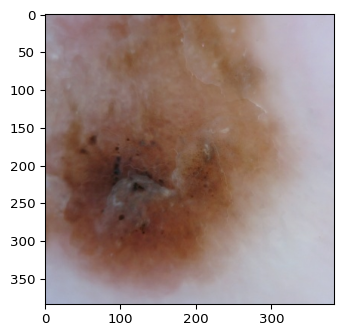

ISIC_0053555.png  Real: Melanoma  - Predicción:[0.9999519]


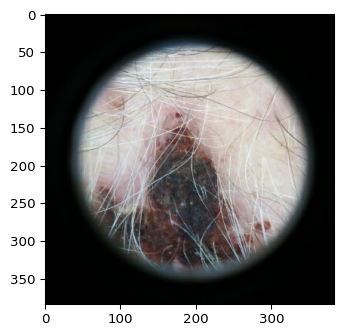

ISIC_0053618.png Real: No melanoma  - Predicción:[0.00095882]


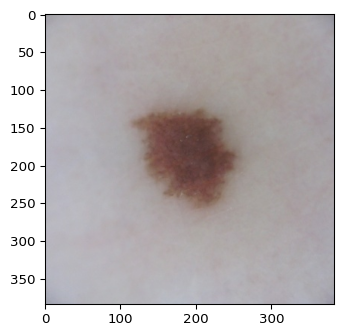

In [ ]:
# Muestra 10 ejemplos de diagnósticos
limit = 0
for img, file, target in iter(get_test_dataset(test_datasets[MODEL_RESOLUTION]).unbatch()):
  plt.figure(figsize=(384/MY_DPI, 384/MY_DPI), dpi=MY_DPI)
  file_name = file.numpy().decode('ascii') + '.png'
  target_diag = " Real: Melanoma" if target.numpy() else "Real: No melanoma"
  # target_diag = target.numpy()
  image = np.clip(img.numpy() * 255, 0, 255).astype(np.uint8)
  image = PIL.Image.fromarray(image)
  tensor = tf.keras.utils.img_to_array(image) / 255
  tensor = tf.expand_dims(tensor,0)
  prediction = " - Predicción:" +  str(model2.predict(tensor, verbose=0).flatten())
  print(file_name, target_diag, prediction)
  plt.imshow(image)
  plt.show()
  image.save("/content/drive/MyDrive/TFG/ISIC/" + file_name)
  limit = limit + 1
  if limit == 10: break

In [ ]:
# Prepara un fichero CSV con el nombre del fichero de fotografía, diagnóstico real y predicción
import csv  
!mv /content/drive/MyDrive/TFG/TFG_mejor_modelo_pred.csv /content/drive/MyDrive/TFG/TFG_mejor_modelo_pred.csv.back
header = ['image_name', 'target', 'prediction']
with open('/content/drive/MyDrive/TFG/TFG_mejor_modelo_pred.csv', 'w', encoding='UTF8') as f:
  writer = csv.writer(f)
  # Cabecera
  writer.writerow(header)
  idx = 0
  for img, file, target in iter(get_test_dataset(test_datasets[MODEL_RESOLUTION]).unbatch()):
    writer.writerow([file.numpy().decode('ascii'), 
          target.numpy(), 
          y_pred[idx]])
    idx = idx + 1

Exception ignored in: <function Executor.__del__ at 0x7ff0d3dabe50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


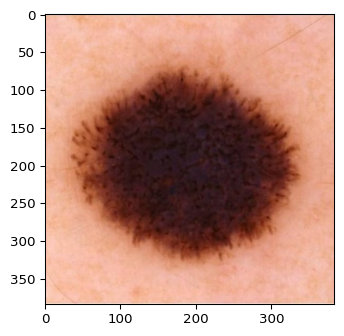

[0.00579348]


In [ ]:
# Ejemplo de un diagnóstico desde una fotografía
plt.figure(figsize=(384/MY_DPI, 384/MY_DPI), dpi=MY_DPI)
image = PIL.Image.open("/content/drive/MyDrive/TFG/ISIC/ISIC_0000199.png")
plt.imshow(image)
plt.show()
tensor = tf.keras.utils.img_to_array(image) / 255
tensor = tf.expand_dims(tensor,0)
prediction = model2.predict(tensor, verbose=0).flatten()
print(prediction)